<center>
<img src="https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/img/this_is_data_anal.png" width="200" height="200"><br>
</center>

# ch.05 데이터 종합 분석 예제

## 5.1 중고나라 휴대폰 거래가격 예측하기

이번 예제에서 사용하는 데이터는 https://www.data.go.kr/ 에서 제공하는 '네이버 중고나라' 데이터, 그리고 통신 3사 사이트에서 제공하는 휴대폰 공시가격 데이터를 기반으로 만들어진 것이다.

### step.1 탐색적 분석: 중고나라 데이터 분석하기

예제에서 사용할 중고나라 데이터셋은 다음과 같은 피처로 구성되어 있다.

- create_date : 판매(or 구매) 게시글이 올라온 시점
- price : 게시글 작성자가 제안한 휴대폰의 거래가격
- text : 게시글의 제목과 본문을 합친 텍스트 데이터
- phone_model : 휴대폰의 기종
- factory_price : 휴대폰의 공시가격
- maker : 휴대폰 제조사
- price_index : 판매 게시글이 올라온 시점에서의 휴대폰 물가 지수 데이터

- 중고나라 데이터셋 살펴보기

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('/home/jaeyoon89/python-data-analysis/data/used_mobile_phone.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4951 entries, 0 to 4950
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   create_date    4951 non-null   object 
 1   price          4951 non-null   float64
 2   text           4951 non-null   object 
 3   phone_model    4951 non-null   object 
 4   factory_price  4951 non-null   int64  
 5   maker          4951 non-null   object 
 6   price_index    4951 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 270.9+ KB
None


,create_date,price,text,phone_model,factory_price,maker,price_index
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96
1,2016-10-26 12 08 00 PM,380000.0,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05
2,2016-10-25 12 52 00 PM,300000.0,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05
3,2017-03-23 11 14 00 PM,290000.0,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96
4,2016-04-11 7 35 00 PM,280000.0,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59


다음으로 개별 피처들을 탐색한다.

- 개별 피처 탐색하기 : date 피처 탐색

In [4]:
# create_date로 부터 '월'을 의미하는 month 정보를 피처로 추출한다.
df['month'] = df['create_date'].apply(lambda x : x[:7])

# 월별 거래 횟수를 계산하여 출력한다.
df['month'].value_counts()

2016-10    2956
2017-03    1311
2016-08     107
2016-09     105
2016-04     102
2016-05      89
2016-06      76
2016-07      74
2016-03      70
2016-02      61
Name: month, dtype: int64

date 피처에서 월별 게시글의 개수를 살펴본 결과, 이 데이터는 2016년 10월과 2017년 3월에 집중적으로 수집된 데이터라는 것을 알 수 있다.
데이터의 개수를 일자별 시계열 그래프로도 나타내보자.

- 개별 피처 탐색하기: date 피처 탐색

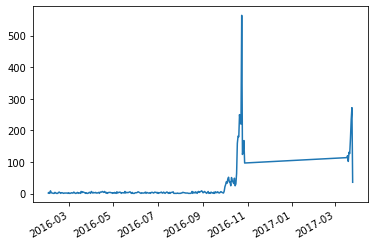

In [5]:
# 일별 거래 횟수를 계산하여 그래프로 출력한다.
df_day = pd.to_datetime(df['create_date'].apply(lambda x : x[:10])).value_counts()
df_day.plot()
plt.show()

그리고 아래와 같이 price 피처의 탐색을 통해 중고나라에서 거래되고 있는 중고 휴대폰의 가격이 어느 정도인지 살펴볼 수 있다. 그래프의 분포를 살펴보면, 대부분의 중고 휴대폰이 60만원 이하의 가격대를 형성하고 있고, 몇몇은 그 이상에도 거래되는 것을 볼 수 있다.

- 개별 피처 탐색하기 : price 피처 탐색


<AxesSubplot:>

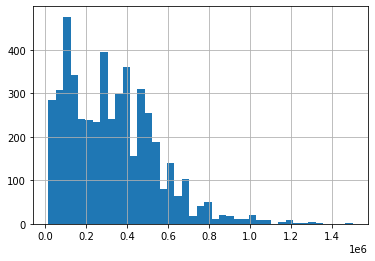

In [8]:
# 가격의 분포를 그래프로 탐색한다.
df['price'].hist(bins="auto")

이번엔 휴대폰의 동일 기종 내에서의 가격 분포를 살펴보자. 이를 위해 phone_model을 grouby하여 그룹별 평균값과 표준편차를 구한 뒤, 모든 price의 z-score를 계산하였다. 이 값은 '동일기종' 내에서의 상대적 가격을 나타낸 값이다.

- 개별 피처 탐색하기 : price 피처 탐색

<AxesSubplot:>

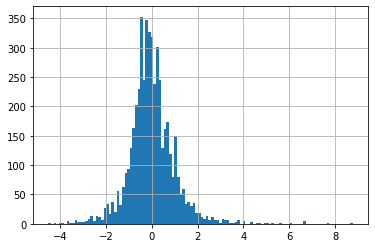

In [9]:
# 휴대폰 기종(phone_model)별 가격의 평균과 표준편차를 계산한다.
df_price_model_mean = df.groupby('phone_model')['price'].transform(lambda x: np.mean(x))
df_price_model_std = df.groupby('phone_model')['price'].transform(lambda x: np.std(x))

# 이를 바탕으로 모든 데이터의 z-score를 계산한다. 이는 해당 데이터의 가격이 기종별 평균에 비해 어느 정도로 높거나 낮은지를 
# 알 수 있게 하는 점수이다.
df_price_model_z_score = (df['price'] - df_price_model_mean) / df_price_model_std
df_price_model_z_score.hist(bins="auto")

이 그래프로 출력한 결과, 동일 기종 내에서 price 피처의 분포는 정규분포에 가깝다는 것을 알 수 있다.
이번엔 factory_price 피처의 분포, 그리고 factory_price와 price 간의 관계를 탐색해 보자.

- 개별 피처 탐색하기 : factory_price 피처 탐색

<AxesSubplot:xlabel='factory_price', ylabel='price'>

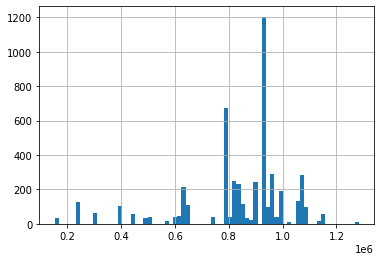

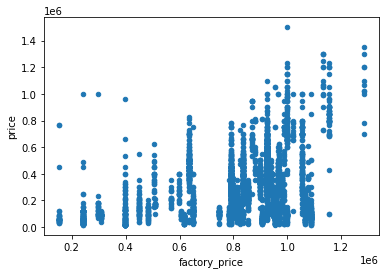

In [10]:
# factory_price 피처의 분포를 탐색한다.
df['factory_price'].hist(bins="auto")

# factory_price와 price 피처를 산점도 그래프로 출력하여 상관 관계를 살펴본다.
df.plot.scatter(x='factory_price', y='price')

위 그래프의 출력 결과, 두 피처는 양의 상관 관계를 가지고 있다. 이를 통해 factory_price는 중고 휴대폰 판매 가격에 꽤 중요한 영향을 미친다. 다음으로 phone_model 피처를 탐색한 결과, 휴대폰 기종의 개수는  총 64개로 나타났다. 상위 5개의 기종을 제외하면 대부분 10 ~ 90개 사이의 데이터를 가지고 있다는 것을 알 수 있다.

- 개별 피처 탐색하기 : phone_model 피처 탐색

count      64.000000
mean       77.359375
std       143.432786
min        10.000000
25%        23.000000
50%        35.000000
75%        90.500000
max      1002.000000
Name: phone_model, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x7f0892137588>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0892137b38>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0892137320>],
 'medians': [<matplotlib.lines.Line2D at 0x7f08920c6128>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f08920c6400>],
 'means': []}

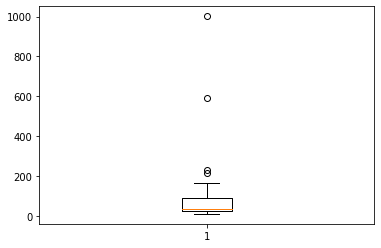

In [13]:
# 기종별 총 거래 데이터 개수를 집계한다.
model_counts = df['phone_model'].value_counts()
print(model_counts.describe())

# 기종별 총 거래 데이터 개수를 상자 그림으로 살펴보자.
plt.boxplot(model_counts)

지금까지 탐색한 피처를 바탕으로 가격 예측 모델을 학습해보자. 그 과정에서 도출되는 피처 중요도 분석을 통해 어떤 피처가 예측 모델에 중요한 피처인지를 알 수 있다. 이러한 분석은 렌덤포레스트라는 모델로 수행할 수 있다.

- 렌덤 포레스트 모델이란?

렌덤포레스트 모델은 앞서 살펴보았던 의사결정 나무 분석 방법을 응용한 것으로 의사 결정 나무를 여러 개 모아 하나의 숲을 구성하는 방법이다. 하나의 모델이 정답을 푸는 것이 아닌, 여러 개의 모델이 정답을 함께 푸는 것이기 때문에 더 정확한 학습이 가능하다.또한 이 방법은 모델이 생성되는 과정에서의 피처 중요도를 계산하기 때문에 탐색적 데이터 분석에 자주 사용된다. 랜덤 포레스트 모델은 회귀와 분류, 두 가지에 모두 적용이 가능하다.

렌덤 포레스트는 sklearn 라이브러리의 RandomForestRegressor 클래스로 사용 가능하다. 이 클래스의 fit 함수를 실행하여 모델을 학습한 뒤, feature_importances_를 출력하면 피처 중요도를 출력할 수 있다. 아래의 실행 결과는 모델의 예측 평가 점수인 R2 score, RMSE를 나타낸 것이다. Train score와 Test score의 차이가 심한 것을 미루어 볼 때, 이 예측 모델은 과적합이 일어났다고 할 수 있다.

- Random forest regressor를 이용한 가격 예측

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [15]:
# 데이터를 학습/테스트용 데이터로 분리한다.
df = df[['price','phone_model','factory_price','maker','price_index','month']]
df = pd.get_dummies(df,columns=['phone_model','maker','month'])
X = df.loc[:, df.columns !='price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)

In [16]:
# 랜덤 포레스트 모델을 학습한다.
forest = RandomForestRegressor(n_estimators=1000,
                              criterion='mse')
forest.fit(X_train,y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

In [17]:
# 학습한 모델을 평가한다.
print('MSE train: %.3f, test: %.3f' %(mean_squared_error(y_train,y_train_pred),
                                     mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f'%(r2_score(y_train, y_train_pred),
                                    r2_score(y_test, y_test_pred)))

MSE train: 10627101903.747, test: 13893562912.669
R^2 train: 0.781, test: 0.682
